In [1]:
#!pip install scipy
import numpy as np, pandas as pd 
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from datetime import datetime

import warnings
warnings.simplefilter (action='ignore', category=(FutureWarning, UserWarning))



In [2]:
#convert T1/T2 nvj rate analysis data into one DataFrame.
#current expected files are <sample>_<expt>rates.txt and <sample>_<expt>tau.txt # adjust as needed
#python note: sample is a protected word, can't use blah_df.sample because it means something else

#data_dir = '/home/pmagala/NMRDATA/2023data/100523_HDXNMR_600'
data_dir = '/home/tuttle/data/nmrdata/FimH/HDX_NMR/100523_HDXNMR_600'

#samples = ['WT', 'WTMannose', 'L34A','L34AMannose','L34K','L34KMannose','27C-34C','27C-34CMannose']
#samples = ['gal4AD','gal4AD_ABD1']
residues = range(1,167) #I have numbered side chain residues as e.g. 840.ne is 8400, otherwise get duplicate residues
#exp=['T1','T2']

newrows=[]

sample = 'WTLD'
expt = 'HDX'
df=os.path.join(data_dir,"rates_hdx")
f=os.path.join(data_dir,"HDX_Table")

delaydict=dict()

delayobject = open(df)
for line in delayobject:
    values = line.rstrip().replace('\t',' ').split(' ')
    if len(values)==2:   #ignore blank lines at end of file
        delaydict['T'+values[0]]=float(values[1])
    #print(values)
#print(delaydict)

data = pd.read_csv(f,delimiter="\t").dropna()
for record in data.to_records():
        for i in range(1,len (delaydict)+1): #since there are 8 delays used for each experiment
                newrow = {'Residue':int(record['Residue']), #removed conversion to string to autosort residue order
                            'sample':sample,
                            'expt':expt,
                            'Intensity':record['T'+str(i)],
                            'delay':delaydict['T'+str(i)]}
                newrows.append(newrow)

dynamics=pd.DataFrame.from_records(newrows)

#dummy adjustment to get rid of _1.ft2 which is in H2O
dynamics = dynamics[dynamics['delay'] != 5]

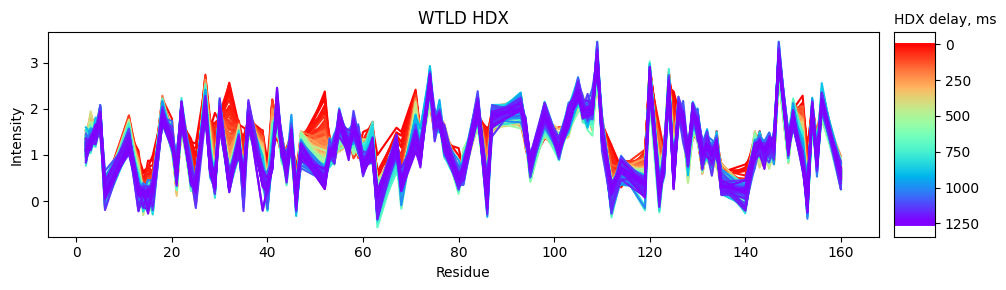

In [3]:
# sample = 'gal4AD'
# expt = 'T1'
fig, ax = plt.subplots(1,2,figsize=(10, 3), gridspec_kw={'width_ratios':[20,1]} )
plot_data = dynamics.copy()[(dynamics['sample'] == sample) & (dynamics['expt']==expt)]
plot_data = plot_data.sort_values('Residue')
plot_data = plot_data[plot_data['Residue'].isin(residues)]
#plot_data = plot_data[plot_data['Residue'].isin(residues)]
delays = sorted(plot_data['delay'].unique())
color = iter(cm.rainbow(np.linspace(1,0,len(delays))))
padding = .075*delays[-1] #this value is for the colorbar to make sure bands don't fall on top and bottom edges

for delay in delays:
    c = next(color)
    plot_data[plot_data['delay']==delay].plot(x='Residue',y='Intensity',ax=ax[0],c=c)
    ax[0].set_ylabel("Intensity")
    ax[1].plot([0,1],[delay,delay],color=c,linewidth=4)
    ax[1].yaxis.tick_right()
    ax[1].axes.get_xaxis().set_visible(False)
ax[0].get_legend().remove()
ax[0].set_title(sample+" "+expt)
ax[1].set_title(expt+" delay, ms",fontsize=10, loc="left")
ax[1].set_ylim(delays[-1]+padding,delays[0]-padding)
#fig.suptitle(sample+" "+expt)
fig.tight_layout()
plt.show()

In [4]:
## curve fitting...

def expdecay(time, Iref, rate, b):
    return Iref * np.exp(-1*rate*time) + b


fits = []


noise = [0.5] #should be picked correctly, this is just a dummy value

expt_data = dynamics.copy()[(dynamics.expt == expt) & (dynamics['sample'] == sample)]
#print(expt_data)
peaks = expt_data.Residue.unique()
for peak in peaks:
    focal_data = expt_data.copy()[expt_data.Residue == peak]
    #focal_data = focal_data.copy()[focal_data.Intensity > noise[0]] #experimental filtering by noise
    
    x = list(focal_data.delay) #could convert minutes to seconds
    y = list(focal_data.Intensity)
    y_err = noise * len(y)
    
    Iinit = focal_data.Intensity.max()
    Iinf = max(noise[0],focal_data.Intensity.min())
    rate_guess = abs(Iinit/Iinf) * 5e-3
    x0 = [Iinit, rate_guess, Iinf] 
    
    
    if len(focal_data) > 2:
        fit,covar = curve_fit(expdecay, x, y, sigma=y_err, p0=x0,maxfev=20000)
        adj_rate = fit[1] if Iinit - Iinf > noise[0] else 1.0
        fits.append( [peak, sample, expt, fit[1], covar[1][1], fit[0], covar[0][0], fit[2], covar[2][2]] + [adj_rate] )

fit_dyn = pd.DataFrame(fits, columns=['Residue', 'sample', 'expt', 'rate', 'rate_err', 'Iref', 'Iref_err','Iinf', 'Iinf_err','adj_rate'])
#fit_dyn['adj_rate'] = np.where( (fit_dyn.Iref - fit_dyn.Iinf) > noise[0], fit_dyn.rate, 1.0) #adjusted rate of 1.0 if Iref < Iinf ~already exchanged
fit_dyn.head(3)



,Residue,sample,expt,rate,rate_err,Iref,Iref_err,Iinf,Iinf_err,adj_rate
0,119,WTLD,HDX,2.597670e-03,9.307102e-08,0.770761,9.345839e-04,0.264805,6.638959e-04,2.597670e-03
1,131,WTLD,HDX,6.229877e-07,1.494608e-06,-203.088610,1.604341e+11,203.930260,1.604341e+11,6.229877e-07
2,133,WTLD,HDX,5.829347e-07,1.160494e-06,-204.695611,1.349183e+11,205.550320,1.349183e+11,5.829347e-07


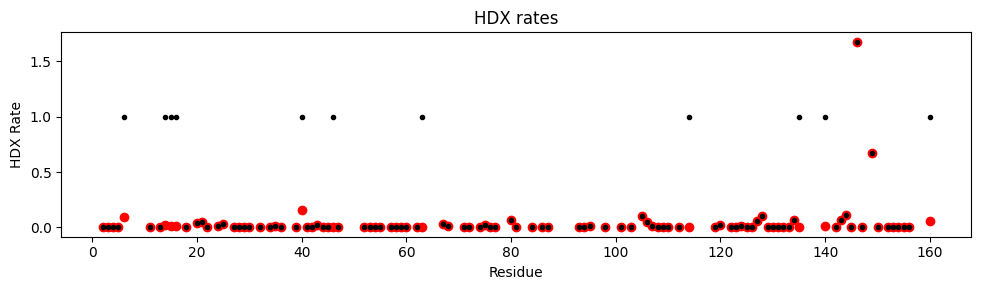

In [5]:
def fill_missing_range(df, field, range_from, range_to, range_step=1, fill_with=0):
    '''
    https://stackoverflow.com/a/43001606/21943039
    use this to fill in missing data to plot full residue range with gaps
    '''
    return df\
      .merge(how='right', on=field,
            right = pd.DataFrame({field:np.arange(range_from, range_to, range_step)}))\
      .sort_values(by=field).reset_index().fillna(fill_with).drop(['index'], axis=1)

compare_samples = [sample] #['gal4AD_ABD1']
# expt = 'T2'
color = iter(cm.rainbow(np.linspace(1,0,len(compare_samples))))
fig2, ax2 = plt.subplots(1,1,figsize=(10, 3), )#gridspec_kw={'width_ratios':[20,1]} )
for sample in compare_samples:
      c = next(color)
      plot_data = fit_dyn.copy()[(fit_dyn['sample'] == sample) & (fit_dyn['expt']==expt)]
      plot_data = plot_data[plot_data['Residue'].isin(residues)]
      plot_data = fill_missing_range(plot_data,'Residue',residues[0],residues[-1],1,np.nan)
      #plot_data.plot.bar(x='Residue',y='rate',yerr='stderr',ax=ax2,width=1.0,ec='black',color=c)
      plot_data.plot(x='Residue',y='rate',ax=ax2,c=c,label=sample,marker='o',linestyle="None" ) #yerr='stderr'
      plot_data.plot(x='Residue',y='adj_rate',ax=ax2,c='black',label=sample,marker='.',linestyle="None" ) #yerr='stderr'
# 
# 


ax2.set_ylabel(expt+" Rate")
#ax2.set_ylim(0,0.15)
ax2.get_legend().remove()
ax2.set_title(expt+" rates")
#fig2.suptitle(sample+" "+expt)
fig2.tight_layout()
plt.show()

saving figure as  WTLD_HDXNMRfits_30Oct2023.pdf


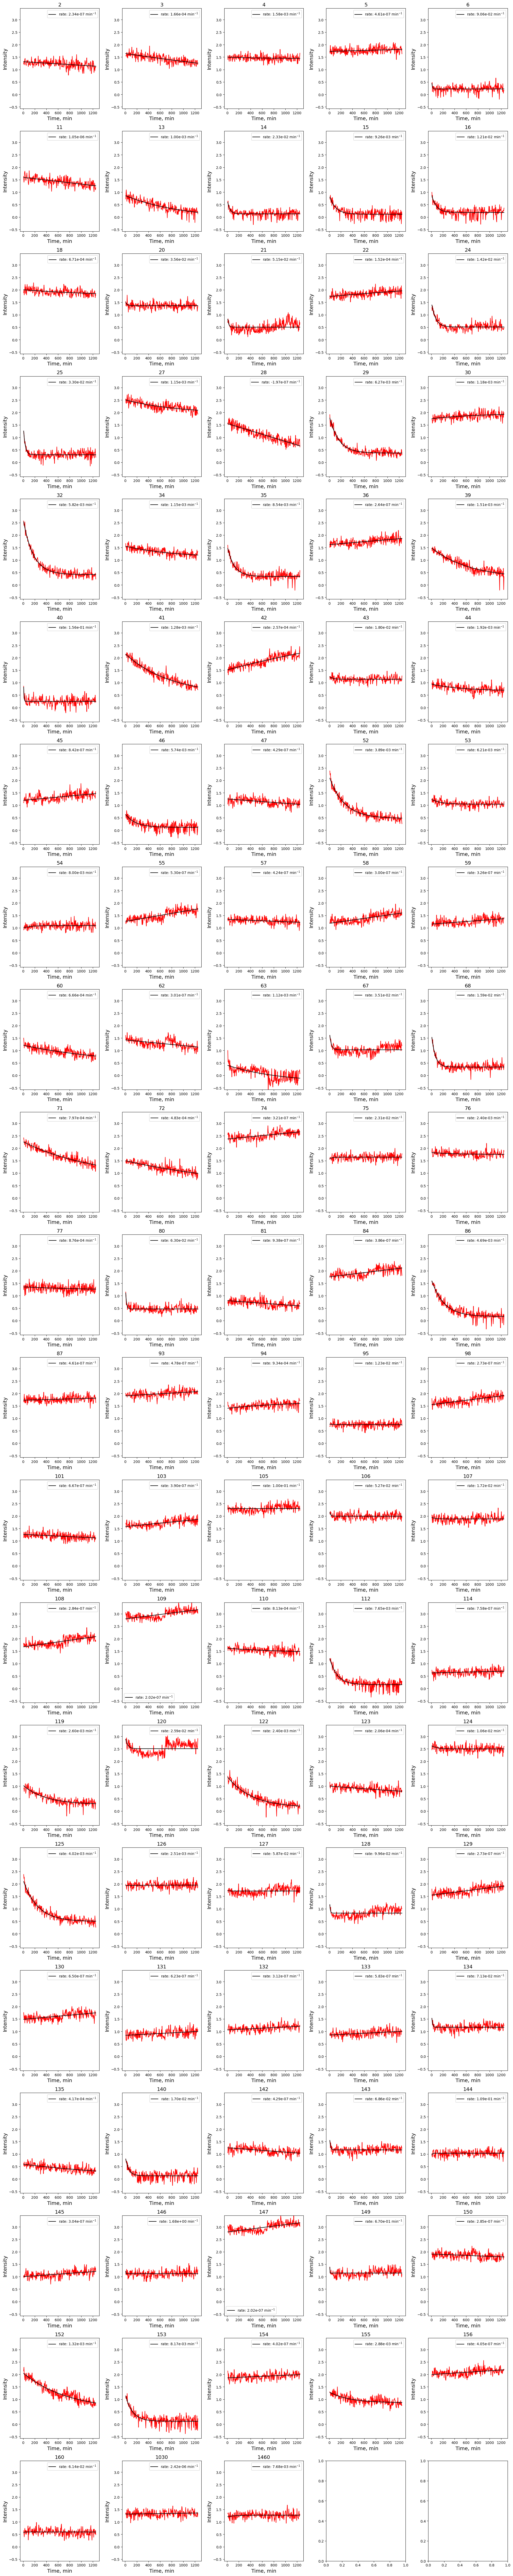

In [9]:
# artificially slow rate for already exchanged residues
# may need to incorporate H2O reference intensity as initial time point somehow to account for this

ncols = 5
nrows=len(peaks) // ncols + 1

fig,ax = plt.subplots(nrows = nrows,ncols=ncols,figsize=(20, 100), )
ipeak = 0
row = 0
col = 0
minI = expt_data.Intensity.min()
maxI = expt_data.Intensity.max()
for peak in sorted(peaks):

    c = 'red'
    focal_data = expt_data.copy()[expt_data.Residue == peak]
    #focal_data = focal_data.copy()[focal_data.Intensity > noise[0]] #experimental filtering by noise
    
    x = list(focal_data.delay) #could convert minutes to seconds
    y = list(focal_data.Intensity)

    Iref = fit_dyn.Iref[(fit_dyn.Residue == peak)].values[0]
    rate = fit_dyn.rate[(fit_dyn.Residue == peak)].values[0]
    Iinf = fit_dyn.Iinf[(fit_dyn.Residue == peak)].values[0]
    y_fit = expdecay(np.asarray(x), Iref, rate, Iinf)


    ax[row,col].plot(x,y,color=c)
    ax[row,col].plot(x,y_fit,color='black',label="rate: "+format(rate,".2e")+" min$^{-1}$")
    ax[row,col].legend()
    ax[row,col].set_xlabel("Time, min",fontsize=14)
    ax[row,col].set_ylabel("Intensity",fontsize=14)
    ax[row,col].set_title(str(peak),fontsize=14)
    ax[row,col].set(ylim=(minI,maxI))
    ipeak = ipeak + 1
    col = ipeak % ncols
    row = ipeak // ncols

fig.tight_layout()


now = datetime.now()
date = now.strftime("%d%b%Y")

try:
    figfile = sample+'_HDXNMRfits_'+date+'.pdf'
    print("saving figure as ",figfile)
    fig.savefig(os.path.join(data_dir,figfile),format='pdf',dpi=600)
    #if hide_figure_output: plt.close(fig)
    #else: plt.show()
except IOError as e:
    print (f"Could not save: {figfile} file is open")  

In [7]:
#this is me playing with how to account for residues that are already fully exchanged at the first time point

fit_dyn['adj_rate'] = np.where(fit_dyn.Iref > fit_dyn.Iinf, fit_dyn.rate, 1.0)
fit_dyn

,Residue,sample,expt,rate,rate_err,Iref,Iref_err,Iinf,Iinf_err,adj_rate
0,119,WTLD,HDX,2.597670e-03,9.307102e-08,0.770761,9.345839e-04,0.264805,6.638959e-04,2.597670e-03
1,131,WTLD,HDX,6.229877e-07,1.494608e-06,-203.088610,1.604341e+11,203.930260,1.604341e+11,1.000000e+00
2,133,WTLD,HDX,5.829347e-07,1.160494e-06,-204.695611,1.349183e+11,205.550320,1.349183e+11,1.000000e+00
3,59,WTLD,HDX,3.260524e-07,2.240895e-07,-531.404821,5.950073e+11,532.555890,5.950073e+11,1.000000e+00
4,132,WTLD,HDX,3.116088e-07,1.591719e-07,-378.131278,2.342939e+11,379.191438,2.342940e+11,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...
98,52,WTLD,HDX,3.892890e-03,2.822807e-08,1.680477,1.147042e-03,0.469144,2.142754e-04,3.892890e-03
99,53,WTLD,HDX,6.214007e-03,4.671555e-06,0.200677,1.758071e-03,1.041801,9.653320e-05,1.000000e+00
100,142,WTLD,HDX,4.286969e-07,inf,412.435720,inf,-411.182542,inf,4.286969e-07
101,6,WTLD,HDX,9.062605e-02,6.927376e-03,0.554851,4.371677e-01,0.220160,6.799704e-05,9.062605e-02


In [8]:
fittest=[]
list(fit)+[1.0]
fittest.append(list(fit)+[1.0])
print(fittest)


[[-138.83302975957542, 4.612148745581099e-07, 140.56169410617804, 1.0]]
